In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Summary

> 1. Successfully implemented the calculation of Batch Normalization. 

> 2. Written in tensorflow and executed using Keras Layers.

> 3. Tested on MNIST dataset. 

> 4. 94% training, validation and test accuracy for 10 epochs.

> 5. Results cross-checked by replacing the custom batch norm calculation with the equation using *momentum* 
     for calculating batch norm as implemented in tensorflow.

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.1.0'

In [4]:
import numpy as np

### Loading data

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [6]:
len(x_train)

60000

In [7]:
x_train.shape

(60000, 28, 28)

In [8]:
type(x_train[0])

numpy.ndarray

In [9]:
x_test.shape

(10000, 28, 28)

In [10]:
np.max(x_train)

255

In [11]:
np.min(x_train)

0

#### Exploring the labels

In [12]:
y_train.shape

(60000,)

In [13]:
type(y_train)

numpy.ndarray

In [14]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

    * data seems decently balanced

In [15]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))

### Visualization

In [16]:
import matplotlib.pyplot as plt

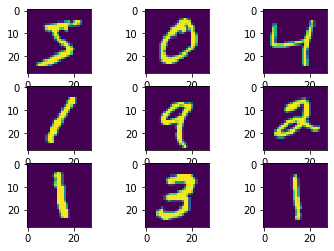

In [17]:
fig, ax = plt.subplots(3,3)
ax = ax.flatten()
for i,j in enumerate(ax):
    
    j.imshow(x_train[i])

### Preprocessing

In [18]:
x_train[0].shape

(28, 28)

In [19]:
x_train = x_train.reshape(-1, 28*28)
x_train.shape

(60000, 784)

In [20]:
x_test = x_test.reshape(-1, 28*28)

#### Scaling the image data

In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
stdscaler = StandardScaler()

In [23]:
stdscaler_fit = stdscaler.fit(x_train)

In [24]:
x_train_scaled = stdscaler_fit.transform(x_train)
x_test_scaled = stdscaler_fit.transform(x_test)

In [25]:
x_train_scaled.dtype

dtype('float64')

In [26]:
x_train_scaled = x_train_scaled.astype(dtype = 'float32', copy=False)

In [27]:
x_train_scaled.dtype

dtype('float32')

In [28]:
x_test_scaled = x_test_scaled.astype(dtype = 'float32', copy=False)

In [29]:
np.max(x_train_scaled)

244.94693

In [30]:
np.min(x_train_scaled)

-1.274208

#### One-hot encoding of y

In [31]:
y_onehot_train = tf.keras.utils.to_categorical(y_train, num_classes=10, dtype='float32')

In [32]:
y_onehot_train.shape

(60000, 10)

In [33]:
# example
y_onehot_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [34]:
y_onehot_test = tf.keras.utils.to_categorical(y_test, num_classes=10, dtype='float32')

#### Creating validation data

In [35]:
from sklearn.utils import shuffle

In [36]:
# for reproducibility
random_seed = 100

In [37]:
x_train_scaled, y_onehot_train = shuffle(x_train_scaled, y_onehot_train, random_state = random_seed)

In [38]:
x_valid_scaled = x_train_scaled[:5000]
y_onehot_valid =  y_onehot_train[:5000]

In [39]:
x_train_scaled = x_train_scaled[5000:]
y_onehot_train =  y_onehot_train[5000:]

#### Creating tf.data.Datasets

In [40]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_scaled, y_onehot_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_scaled, y_onehot_test))
valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid_scaled, y_onehot_valid))

In [41]:
minibatch = 60 # used in the paper

In [42]:
buffersize = len(y_train)
buffersize

60000

In [43]:
train_dataset = train_dataset.shuffle(buffer_size=buffersize, seed=random_seed,
                                     reshuffle_each_iteration=True).batch(minibatch, 
                                                                          drop_remainder = True).prefetch(buffer_size=
                                                                                                          tf.data.experimental.AUTOTUNE)

In [44]:
valid_dataset = valid_dataset.shuffle(buffer_size=buffersize, seed=random_seed, 
                                      reshuffle_each_iteration=False).batch(batch_size=minibatch).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size=buffersize, seed=random_seed, 
                                      reshuffle_each_iteration=False).batch(batch_size=minibatch).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [45]:
for i in test_dataset.take(1):
    print(i[1][0])

tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)


### Creating custom layers and keras model

    * 3 dense layers followed by 3 batch norm layers and a final dense layer with units equal to number of categories

#### Creating Custom Dense Layer

In [46]:
class dense_layer(tf.keras.layers.Layer):
    
    def __init__(self, units, **kwargs):
        
        super(dense_layer, self).__init__(**kwargs)
        self.units =  units
        
    def build(self, input_shape):
        
        self.kernel_weights = self.add_weight(name = 'weights', shape = (input_shape[-1], self.units), 
                                              dtype = self.dtype, initializer=tf.keras.initializers.Orthogonal(gain=1,seed=random_seed),
                                             trainable = self.trainable)
        self.bias = self.add_weight(name = 'bias', shape = (self.units,), dtype = self.dtype,
                                   initializer=tf.keras.initializers.zeros(), trainable = self.trainable)
        
    def call(self, inputs):
        
        return tf.add(tf.matmul(inputs, self.kernel_weights), self.bias)
    
    def get_config(self):
        
        config = super(dense_layer, self).get_config()
        config.update({'units': self.units})
        
        return config

### Custom BatchNorm layer

In [47]:
class custombn_paper(tf.keras.layers.Layer):
    
    """
    Not implementing momentum as defined in the keras BatchNorm layer
    
    Population mean and variance are calculated as defined in the paper
    
    This process can only be used when mini-batch size > 1
    
    """
    
    
    def __init__(self, stateful, **kwargs):
        
        super(custombn_paper, self).__init__(**kwargs)
        
        self.stateful = stateful
      

    def build(self, input_shape):
        
        self.gamma = self.add_weight(name = 'scale', shape = (1, input_shape[-1]), initializer = tf.keras.initializers.ones(),
                                    trainable = self.trainable)
        self.beta = self.add_weight(name = 'shift', shape = (1,input_shape[-1]), initializer = tf.keras.initializers.zeros(),
                                   trainable = self.trainable)
        self.offset = tf.Variable(0.001, dtype = 'float32', trainable=False)
        
        self.moving_mean = self.add_weight(name = 'moving_mean', shape = (1, input_shape[-1]), initializer = tf.keras.initializers.Zeros(),
                                          trainable = False)
        self.moving_var =  self.add_weight(name = 'moving_var', shape = (1, input_shape[-1]), initializer = tf.keras.initializers.Zeros(),
                                          trainable = False)
        
        self.batch_count = tf.Variable(0, dtype = 'float32', name = 'batchcount', trainable=False)
        
        self.batchsize = tf.Variable(2, dtype = 'float32', name='batchsize', trainable=False)

        
        self.init_mm = self.moving_mean.read_value()
        self.init_mv = self.moving_var.read_value()

    
    def bn_training(self, inputs, axes = [0]):

        self.batch_mean, self.batch_var = tf.nn.moments(inputs, axes = axes, keepdims=True)
        
        self.moving_mean.assign_add(self.batch_mean)
        self.moving_var.assign_add(self.batch_var)

        return tf.add(tf.multiply(tf.divide(tf.subtract(inputs, self.batch_mean), 
                                     tf.math.sqrt(tf.add(self.batch_var, self.offset))), self.gamma), self.beta)
    

    
    def update_mm_mv(self):
        """
        Updating mm and mv at the end of epoch
        """        
        self.moving_mean.assign(tf.cond(tf.greater(self.batch_count,0), 
                                        lambda: tf.divide(self.moving_mean,self.batch_count), lambda: self.moving_mean, name='update_mm'))
        
        self.moving_var.assign(tf.cond(tf.greater(self.batch_count,0), 
                                       lambda: tf.multiply(self.moving_var, tf.divide(self.batchsize, tf.multiply(tf.subtract(self.batchsize,1), self.batch_count))),
                                       lambda: self.moving_var, name='update_mv'))
        
    
    def bn_inference(self, inputs):
        
        return tf.add(tf.multiply(tf.divide(tf.subtract(inputs, self.moving_mean), 
                                     tf.math.sqrt(tf.add(self.moving_var, self.offset))), self.gamma), self.beta)
        
        
        
    def reset_states(self):

        self.moving_mean.assign(self.init_mm)
        self.moving_var.assign(self.init_mv)

    def call(self, inputs, training):       
        
        return tf.cond(tf.equal(training, True, name='train_or_eval'),lambda: self.bn_training(inputs), lambda: self.bn_inference(inputs),
                      name = 'call_func') 

    def get_config(self):
        
        config = super(custombn_paper, self).get_config()
        config.update({'stateful': self.stateful})
        
        return config
        

In [48]:
def reset_graph():
    tf.keras.backend.clear_session()

In [49]:
reset_graph()

### Model fitting

In [50]:
def model_func_bnpaper(inputshape = [1], units1 = 100, units2 =100, units3=100, classes=10):
    
    input_lyr = tf.keras.Input(shape = inputshape, batch_size=None, name = 'input')
    
    dense1 = dense_layer(units = units1, name = 'dense1', trainable = True)(input_lyr)
    custombn1 = custombn_paper(stateful = True, name = 'bn1', trainable = True)(dense1)     
    activation1 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv1')(custombn1)
    
    dense2 = dense_layer(units = units2, name = 'dense2', trainable = True)(activation1)    
    custombn2 = custombn_paper(stateful = True, name = 'bn2', trainable = True)(dense2)     
    activation2 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv2')(custombn2)
    
    dense3 = dense_layer(units = units3, name = 'dense3', trainable = True)(activation2)    
    custombn3 = custombn_paper(stateful = True, name='bn3', trainable = True)(dense3)     
    activation3 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv3')(custombn3)
    
    
    output_lyr = dense_layer(units = classes, name='output') (activation3)
    # no softmax 
    
    return tf.keras.Model(inputs = [input_lyr], outputs = [output_lyr])

### Custom Callbacks

#### *Callback for resetting moving mean and variances at the end of each epoch*

In [51]:
class custom_callback(tf.keras.callbacks.Callback):
    
    """
    This callback resets the moving mean and variances at the end of each epoch.
    """
    
    def __init__(self, batchsize, **kwargs):
        
        super(custom_callback, self).__init__(**kwargs)
                
        self.batchsize = batchsize
        self.batchcount = tf.Variable(0, dtype = tf.int32, trainable=False)
        
        
    def on_train_begin(self, logs =None):
        """
        At the beginning of the training, the batchsize is assigned to
        the batchsize variables of the bn layers for correct calc. of 
        the mm/mv.        
        """
        for layer in self.model.layers:
            if layer.__class__.__name__ == 'custombn_paper':
                layer.batchsize.assign(self.batchsize)      
        
    
    
    def on_train_batch_end(self, batch, logs=None):
        """
        This function in combination with functions below
        is used to pass the total number of batches in the training data
        for the calculation of mm/mv.
        """
        self.batchcount.assign(batch)
        tf.cond(tf.equal(self.batchcount,1), self.at_batch_one, self.at_batch_not_one)     
        
    def at_batch_one(self):
        """
        When the first batch of the training data has been processed 
        this function retrieves the total batches(steps) and updates
        the corresponding variable in the batch norm layers for 
        calculating moving mean and moving var.                  
        """
        
        for layer in self.model.layers:
            if layer.__class__.__name__ == 'custombn_paper':

                layer.batch_count.assign(self.model.history.params['steps'])

        return None
        
    def at_batch_not_one(self):
        tf.cond(tf.equal(self.batchcount, self.model.history.params['steps']-1), self.at_last_batch, self.at_any_batch)
    
    def at_last_batch(self):
        """
        This layer updates mm/mv after the last batch of the 
        training data has been processed.        
        """
        for layer in self.model.layers:
            if hasattr(layer, 'update_mm_mv'):
                layer.update_mm_mv()
        
        return None
    
    def at_any_batch(self):
        """
        Nothing to do any other batch number
        """
        return None

       
    def on_epoch_begin(self, epoch, logs = None):
        """
        At the beginning of every epoch, the mm/mv need to be reset to zero.
        """
        
        self.model.reset_states()       


#### *Callback for saving best model*

In [52]:
import os

In [53]:
custom_bnlayer_model = 'cstm_bnlayer_model'

if os.path.exists(custom_bnlayer_model):
    pass
else:
    os.mkdir(custom_bnlayer_model)

In [54]:
cb_savemodel = tf.keras.callbacks.ModelCheckpoint(os.path.join(custom_bnlayer_model, 'model_{epoch}-{val_loss:.3f}.h5'), mode = 'min',\
                                                 monitor = 'val_loss', save_best_only=True)

#### *Callback for Visualizing in TensorBoard*

In [55]:
custom_bnlayer_logs = 'cstm_bnlayer_logs'

if os.path.exists(custom_bnlayer_logs):
    pass
else:
    os.mkdir(custom_bnlayer_logs)

In [56]:
cstm_tb = tf.keras.callbacks.TensorBoard(log_dir = custom_bnlayer_logs, histogram_freq=1, write_graph=True,\
                                        write_images=True)

In [57]:
cb_list = []
cb_list.append([cstm_tb,cb_savemodel, custom_callback(batchsize=60)]) 
cb_list = cb_list[0]
cb_list

    * Adam optimizer has adaptive learning rate feature

### Creating a Model using custom defined BN layers

In [58]:
model_bnpaper = model_func_bnpaper(inputshape=(784,))

In [59]:
model_bnpaper.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
dense1 (dense_layer)         (None, 100)               78500     
_________________________________________________________________
bn1 (custombn_paper)         (None, 100)               403       
_________________________________________________________________
actv1 (Activation)           (None, 100)               0         
_________________________________________________________________
dense2 (dense_layer)         (None, 100)               10100     
_________________________________________________________________
bn2 (custombn_paper)         (None, 100)               403       
_________________________________________________________________
actv2 (Activation)           (None, 100)               0     

#### Compiling the Model

In [60]:
model_bnpaper.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),\
                     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                     metrics = [tf.keras.metrics.CategoricalAccuracy()])
# If using softmax as the activation of the last layer, then from_logits should be False

#### Fitting

In [61]:
epochs1=10

In [62]:
cstm_bnlayer_history1 =  model_bnpaper.fit(train_dataset.take(100), epochs=epochs1, verbose=1, 
                                           callbacks=cb_list, validation_data=valid_dataset.take(50), shuffle=True)

Train for 100 steps, validate for 50 steps
Epoch 1/10
100/100 [==============================] - 3s 30ms/step - loss: 0.6130 - categorical_accuracy: 0.8245 - val_loss: 0.3467 - val_categorical_accuracy: 0.9017
Epoch 2/10
100/100 [==============================] - 1s 12ms/step - loss: 0.3456 - categorical_accuracy: 0.9018 - val_loss: 0.3170 - val_categorical_accuracy: 0.9100
Epoch 3/10
100/100 [==============================] - 1s 10ms/step - loss: 0.3093 - categorical_accuracy: 0.9093 - val_loss: 0.2710 - val_categorical_accuracy: 0.9203
Epoch 4/10
100/100 [==============================] - 1s 8ms/step - loss: 0.2579 - categorical_accuracy: 0.9240 - val_loss: 0.2437 - val_categorical_accuracy: 0.9293
Epoch 5/10
100/100 [==============================] - 1s 10ms/step - loss: 0.2528 - categorical_accuracy: 0.9257 - val_loss: 0.2375 - val_categorical_accuracy: 0.9307
Epoch 6/10
100/100 [==============================] - 1s 9ms/step - loss: 0.2201 - categorical_accuracy: 0.9378 - val_loss:

In [63]:
# test dataset
model_bnpaper.evaluate(test_dataset)

167/167 [==============================] - 0s 2ms/step - loss: 0.1842 - categorical_accuracy: 0.9459


[0.18415349675063603, 0.9459]

In [64]:
del model_bnpaper
reset_graph()

### Testing the custom BN against the method implemented in tensorflow using Momentum

In [65]:
class custombn_keras(tf.keras.layers.Layer):
    
    """
    Implementing momentum as defined in the keras BatchNorm layer to calculate
    
    population mean and variance 
    
    """
    
    
    def __init__(self, momentum, stateful, **kwargs):
        
        super(custombn_keras, self).__init__(**kwargs)
        
        self.momentum = momentum
        self.stateful = stateful
        
    def build(self, input_shape):
        
        self.gamma = self.add_weight(name = 'scale', shape = (1, input_shape[-1]), initializer = tf.keras.initializers.ones(),
                                    trainable = self.trainable)
        self.beta = self.add_weight(name = 'shift', shape = (1,input_shape[-1]), initializer = tf.keras.initializers.zeros(),
                                   trainable = self.trainable)
        self.offset = tf.Variable(0.001, dtype = 'float32', trainable=False)
        
        self.moving_mean = self.add_weight(name = 'moving_mean', shape = (1, input_shape[-1]), initializer = tf.keras.initializers.Zeros(),
                                          trainable = False)
        self.moving_var =  self.add_weight(name = 'moving_var', shape = (1, input_shape[-1]), initializer = tf.keras.initializers.Zeros(),
                                          trainable = False)
        
        self.init_mm = self.moving_mean.read_value()
        self.init_mv = self.moving_var.read_value()
        
    
    def bn_training(self, inputs, axes = [0]):
        
        
        self.batch_mean, self.batch_var = tf.nn.moments(inputs, axes = axes, keepdims=True)
        
        self.moving_mean.assign((1-self.momentum)*self.moving_mean + self.momentum*self.batch_mean)
        # as implemented in tensorflow
        self.moving_var.assign((1-self.momentum)*self.moving_var + self.momentum*self.batch_var)
        
        
        return tf.add(tf.multiply(tf.divide(tf.subtract(inputs, self.batch_mean), 
                                     tf.math.sqrt(tf.add(self.batch_var, self.offset))), self.gamma), self.beta)
    
    def bn_inference(self, inputs):        
        
        return tf.add(tf.multiply(tf.divide(tf.subtract(inputs, self.moving_mean), 
                                     tf.math.sqrt(tf.add(self.moving_var, self.offset))), self.gamma), self.beta)
        
        
    def reset_states(self):
        
        self.moving_mean.assign(self.init_mm)
        self.moving_var.assign(self.init_mv)
        
        
    def call(self, inputs, training):     
        
        return tf.cond(tf.equal(training, True),lambda: self.bn_training(inputs), lambda: self.bn_inference(inputs))       
    
    def get_config(self):
        
        config = super(custombn_keras, self).get_config()
        config.update({'momentum': self.momentum})
        
        return config
        

#### Model function using custombn_keras

In [66]:
def model_custombn_keras(inputshape = [1], units1 = 100, units2 =100, units3=100, classes=10):
    
    input_lyr = tf.keras.Input(shape = inputshape, batch_size=None, name = 'input')
    
    dense1 = dense_layer(units = units1, name = 'dense1', trainable = True)(input_lyr)
    custombn1 = custombn_keras(momentum = 0.99, stateful = True, name = 'bn1', trainable = True)(dense1)     
    activation1 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv1')(custombn1)
    
    dense2 = dense_layer(units = units2, name = 'dense2', trainable = True)(activation1)    
    custombn2 = custombn_keras(momentum = 0.99, stateful = True, name = 'bn2', trainable = True)(dense2)     
    activation2 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv2')(custombn2)
    
    dense3 = dense_layer(units = units3, name = 'dense3', trainable = True)(activation2)    
    custombn3 = custombn_keras(momentum = 0.99, stateful = True, name='bn3', trainable = True)(dense3)     
    activation3 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv3')(custombn3)
    
    
    output_lyr = dense_layer(units = classes, name='output') (activation3)
    # no softmax 
    
    return tf.keras.Model(inputs = [input_lyr], outputs = [output_lyr])

In [67]:
modelbn_keras = model_custombn_keras(inputshape=(784,))

In [68]:
modelbn_keras.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
dense1 (dense_layer)         (None, 100)               78500     
_________________________________________________________________
bn1 (custombn_keras)         (None, 100)               401       
_________________________________________________________________
actv1 (Activation)           (None, 100)               0         
_________________________________________________________________
dense2 (dense_layer)         (None, 100)               10100     
_________________________________________________________________
bn2 (custombn_keras)         (None, 100)               401       
_________________________________________________________________
actv2 (Activation)           (None, 100)               0     

In [69]:
for layer in modelbn_keras.layers:
    print(layer.stateful)

False
False
True
False
False
True
False
False
True
False
False


In [70]:
modelbn_keras.stateful

True

#### Callbacks

In [71]:
class custombn_keras_callbck(tf.keras.callbacks.Callback):
    """
    For resetting mm/mv after each epoch.
    """
    
    def __init__(self, **kwargs):
        
        super(custombn_keras_callbck, self).__init__(**kwargs)
            
    def on_epoch_begin(self, epoch, logs = None):
        
        self.model.reset_states()


##### Model Saving

In [72]:
custom_bnkeras_svdmodel = 'cstm_bnkeras_svdmodel'

if os.path.exists(custom_bnkeras_svdmodel):
    pass
else:
    os.mkdir(custom_bnkeras_svdmodel)

In [73]:
cb_savemodel = tf.keras.callbacks.ModelCheckpoint(os.path.join(custom_bnkeras_svdmodel, 'model_{epoch}-{val_loss:.3f}.h5'), mode = 'min',\
                                                 monitor = 'val_loss', save_best_only=True)

##### TensorBoard

In [74]:
custom_bnkeras_logs = 'cstm_bnkeras_logs'

if os.path.exists(custom_bnkeras_logs):
    pass
else:
    os.mkdir(custom_bnkeras_logs)

In [75]:
cstm_tb = tf.keras.callbacks.TensorBoard(log_dir = custom_bnkeras_logs, histogram_freq=1, write_graph=True,\
                                        write_images=True)

In [76]:
cb_list = []
cb_list.append([cstm_tb,cb_savemodel, custombn_keras_callbck()]) 
cb_list = cb_list[0]
cb_list

#### Compiling and Fitting

In [77]:
modelbn_keras.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                     metrics = [tf.keras.metrics.CategoricalAccuracy()])

#### Fitting

In [78]:
epochs1=10

In [79]:
custombn_keras_history1 =  modelbn_keras.fit(train_dataset.take(100), epochs=epochs1, verbose=1, 
                                           callbacks=cb_list, validation_data=valid_dataset.take(50), shuffle=True)

Train for 100 steps, validate for 50 steps
Epoch 1/10
100/100 [==============================] - 3s 31ms/step - loss: 0.6186 - categorical_accuracy: 0.8262 - val_loss: 0.4266 - val_categorical_accuracy: 0.8663
Epoch 2/10
100/100 [==============================] - 1s 10ms/step - loss: 0.3411 - categorical_accuracy: 0.9007 - val_loss: 0.3290 - val_categorical_accuracy: 0.9080
Epoch 3/10
100/100 [==============================] - 1s 9ms/step - loss: 0.2834 - categorical_accuracy: 0.9152 - val_loss: 0.2924 - val_categorical_accuracy: 0.9187
Epoch 4/10
100/100 [==============================] - 1s 9ms/step - loss: 0.2716 - categorical_accuracy: 0.9193 - val_loss: 0.2992 - val_categorical_accuracy: 0.9117
Epoch 5/10
100/100 [==============================] - 1s 10ms/step - loss: 0.2340 - categorical_accuracy: 0.9297 - val_loss: 0.2533 - val_categorical_accuracy: 0.9273
Epoch 6/10
100/100 [==============================] - 1s 10ms/step - loss: 0.2227 - categorical_accuracy: 0.9328 - val_loss:

In [80]:
modelbn_keras.evaluate(test_dataset)

167/167 [==============================] - 0s 2ms/step - loss: 0.2069 - categorical_accuracy: 0.9371


[0.20693755950667186, 0.9371]

In [82]:
reset_graph()
del modelbn_keras